# TFT fine-tuning notebook

Given the training and validation sets, we fine-tune the time-fusion transformer model for each stock using `optuna`.

In [146]:
%reload_ext autoreload
%autoreload 2
import pandas as pd
import datetime as dt
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict
import numpy as np
import utils
import matplotlib.pyplot as plt
from tqdm import tqdm
from MyDataLoader import MyDataLoader
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss, RMSE, CrossEntropy
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
import torch
import pytorch_lightning as pl
from sklearn.preprocessing import StandardScaler

pd.options.display.max_columns = 500
pd.options.display.max_rows = 500

import json
from Model import Model
import inspect
from torch.utils.data import DataLoader

from PrecisionMatrixBuilder import PrecisionMatrixBuilder
from Forecaster import Forecaster
from MyDataLoader import MyDataLoader
from PortfolioConstructor import PortfolioConstructor
from BackTester import BackTester

In [243]:
dataloader = MyDataLoader()
full_dataset, stock_names, time_index = dataloader.load_full_dataset_array()
column_names = dataloader.load_feature_names()

[*********************100%***********************]  40 of 40 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [244]:
full_dataset = full_dataset[:, :, [k for k in range(len(column_names)) if column_names[k] != "SGN"]]
column_names.pop(1) # drop SGN

'SGN'

In [245]:
config = utils.load_config()
alphas = config["alphas"]
thetas = config["thetas"]
lambdas = config["lambdas"]
capital = config["capital"]

In [246]:
returns = dataloader.load_returns()

In [247]:
benchmark_returns = dataloader.load_benchmark(date_index=time_index)
risk_free = dataloader.load_risk_free_rate(time_index)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [248]:
tscv = list(utils.time_series_cross_validation(full_dataset, time_index, n_splits=10, valid_size=66, test_size=66))
train, time_index_train, valid, time_index_valid, test, time_index_test = tscv[0]

We determine, for each stock, its list of optimal parameters:

In [ ]:
best_trials_params = {}
best_trials_losses = {}
train, time_index_train, valid, time_index_valid, test, time_index_test = tscv[0]
for i in tqdm(range(len(stock_names))):

    data_stock_train = pd.DataFrame(train[:, i, :], index = time_index_train, columns = column_names).reset_index(drop = True).reset_index()
    data_stock_valid = pd.DataFrame(valid[:, i, :], index = time_index_valid, columns = column_names).reset_index(drop = True).reset_index()
    data_stock_train["GRP_ID"] = 0
    data_stock_valid["GRP_ID"] = 0
    
    print(data_stock_train.shape)
    print(data_stock_valid.shape)

    training_dataset = TimeSeriesDataSet(
    data_stock_train,
    target=column_names[0],
    time_idx="index",
    min_encoder_length=30,
    max_encoder_length=60,
    min_prediction_length = 1,
    max_prediction_length = 1,
    time_varying_unknown_reals=column_names,
    time_varying_known_reals = ["index"],
    group_ids=["GRP_ID"],
    )
    
    validation_dataset = TimeSeriesDataSet.from_dataset(
    training_dataset,
    data_stock_valid,
    stop_randomization=True,
    predict = False
    )

    training_dataloader = training_dataset.to_dataloader(batch_size=64, train = True)
    validation_dataloader = validation_dataset.to_dataloader(batch_size=64, train = False)
    
    study = optimize_hyperparameters(
        training_dataloader,
        validation_dataloader,
        model_path=f"optuna_{stock_names[i]}",
        n_trials=3,
        max_epochs=10,
        gradient_clip_val_range=(0.01, 1.0),
        hidden_size_range=(8, 128),
        hidden_continuous_size_range=(8, 128),
        attention_head_size_range=(1, 4),
        learning_rate_range=(0.001, 0.1),
        dropout_range=(0.1, 0.3),
        trainer_kwargs=dict(limit_train_batches=30),
        reduce_on_plateau_patience=4,
        use_learning_rate_finder=False,
        loss = RMSE()
        )
    
    best_trials_params[stock_names[i]] = study.best_trial.params
    best_trials_losses[stock_names[i]] = study.best_trial.value

with open("best_trials_params.json", "w") as f:
    json.dump(best_trials_params, f, indent = 4)

with open("best_trials_losses.json", "w") as f:
    json.dump(best_trials_losses, f, indent = 4)

In [249]:
with open("TFT_best_trials_params.json") as f:
    opt_params = json.load(f)

In [250]:
config = utils.load_config()
alphas = config["alphas"]
thetas = config["thetas"]
lambdas = config["lambdas"]
capital = config["capital"]
returns = dataloader.load_returns()

In [251]:
# precision_matrix_builder = PrecisionMatrixBuilder(returns = returns, window = 512, alphas = alphas, thetas = thetas)
# prec_mat = precision_matrix_builder.get_precision_matrix()
import pickle
with open("precision_mat.pkl", "rb") as f:
    prec_mat = pickle.load(f)

In [252]:
benchmark_returns = dataloader.load_benchmark(date_index=time_index)
risk_free = dataloader.load_risk_free_rate(time_index)

[*********************100%***********************]  1 of 1 completed


In [253]:
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=1e-3,
    patience=3,
    verbose=False,
    mode="min")
lr_logger = LearningRateMonitor()  
trainer = pl.Trainer(
    max_epochs=10,
    devices=1,
    enable_model_summary=False,
    gradient_clip_val=0.1,
    callbacks=[lr_logger, early_stop_callback],
    enable_progress_bar=False,
    )

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [254]:
def fit(model, training_dataloader, num_epochs = 10, type = "regression", optimizer_learning_rate = 1e-3, patience = 3, min_delta = 1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr = optimizer_learning_rate)
    # define optimizer
    for epoch in range(num_epochs):
        running_loss = np.inf
        c = 0
        for batch_idx, batch in enumerate(training_dataloader):
            x, y = batch
            y, _ = y
            y = y.long() if type == "classification" else y
            y_hat = model(x)['prediction']
            loss = model.loss(y_hat, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if abs(running_loss - loss.item()) < min_delta:
                c += 1
            else:
                c = 0
            running_loss = loss.item()
        if c > patience:
            break

def evaluate(model, validation_dataloader, type = "regression"):
    model.eval()
    tot_loss = 0
    with torch.no_grad():
        for batch_idx, batch in enumerate(validation_dataloader):
            x, y = batch
            y, _ = y
            y = y.long() if type == "classification" else y
            y_hat = model(x)
            val_loss = model.loss(y_hat, y)
            tot_loss += val_loss
    return tot_loss

In [255]:
forecasts_val = []
forecasts_test = []

valid_index_full = []
test_index_full = []

weights_valid = defaultdict(list)
weights_test = defaultdict(list)

stock_names = stock_names
time_series_split = tscv

opt_param_dict = defaultdict(list)

model = Model(name = "TimeFusionTransformer", type = "regression", model_class = trainer) # used for PortfolioConstructor

for batch in tqdm(time_series_split):

    train, train_index, valid, valid_index, test, test_index = batch

    valid_index_full.append(valid_index)
    test_index_full.append(test_index)
    
    n_stocks = train.shape[1]

    model_pred_valid = {}
    model_pred_test = {}
        
    for stock in range(n_stocks):

        stock_name = stock_names[stock]
        stock_specific_params = opt_params[stock_name]
        
        stock_train = train[:, stock, :]
        stock_valid = valid[:, stock, :]
        stock_test = test[:, stock, :]
        
        data_stock_train = pd.DataFrame(stock_train, index = train_index, columns=column_names).reset_index(drop = True).reset_index()
        data_stock_valid = pd.DataFrame(stock_valid, index = valid_index, columns=column_names).reset_index(drop = True).reset_index()
        data_stock_test = pd.DataFrame(stock_test, index = test_index, columns=column_names).reset_index(drop = True).reset_index()

        data_stock_train["GRP_ID"] = 0
        data_stock_valid["GRP_ID"] = 0
        data_stock_test["GRP_ID"] = 0

        training_dataset = TimeSeriesDataSet(
            data_stock_train,
            target=column_names[0],
            time_idx="index",
            min_encoder_length=30,
            max_encoder_length=60,
            min_prediction_length = 1,
            max_prediction_length = 1,
            time_varying_unknown_reals=column_names,
            time_varying_known_reals = ["index"],
            group_ids=["GRP_ID"],
            add_relative_time_idx=True,
            add_target_scales=True,
            add_encoder_length=True,
        )

        validation_dataset = TimeSeriesDataSet.from_dataset(
            training_dataset,
            data_stock_valid,
            stop_randomization=True
        )

        test_dataset = TimeSeriesDataSet.from_dataset(
            training_dataset,
            data_stock_test,
            stop_randomization=True
        )

        tft = TemporalFusionTransformer.from_dataset(
            training_dataset, 
            output_size= 1 if model.type == "regression" else 2,
            loss = RMSE() if model.type == "regression" else CrossEntropy(reduction="mean"),
            log_interval=10,
            reduce_on_plateau_patience=4,
            optimizer="adam",
            hidden_size = stock_specific_params["hidden_size"],
            attention_head_size = stock_specific_params["attention_head_size"],
            hidden_continuous_size = stock_specific_params["hidden_continuous_size"],
            learning_rate = stock_specific_params["learning_rate"],
            dropout = stock_specific_params["dropout"]
            )
        
        training_dataloader = training_dataset.to_dataloader(train=True, batch_size=64)
        validation_dataloader = validation_dataset.to_dataloader(train=False, batch_size=64)
        test_dataloader = test_dataset.to_dataloader(train=False, batch_size=64)

        trainer.gradient_clip_val = stock_specific_params["gradient_clip_val"]
        
        if model.type == "regression":
            trainer.fit(
                model = tft,
                train_dataloaders = training_dataloader,
                val_dataloaders = validation_dataloader
                )
        else:
            fit(model = tft, training_dataloader = training_dataloader, num_epochs = 10, type = "classification", optimizer_learning_rate = stock_specific_params["learning_rate"])

        y_valid_pred = pd.Series(tft.predict(validation_dataloader).reshape(-1).numpy(), index = valid_index)
        y_test_pred = pd.Series(tft.predict(test_dataloader).reshape(-1).numpy(), index = test_index)
        
        model_pred_valid[stock_name] = y_valid_pred
        model_pred_test[stock_name] = y_test_pred

    model_pred_valid = pd.concat(model_pred_valid, axis = 1)
    model_pred_test = pd.concat(model_pred_test, axis = 1)

    forecasts_val.append(model_pred_valid)
    forecasts_test.append(model_pred_test)

    if model.type == "regression":
        # validate portfolio optimization parameters
        pc_valid = PortfolioConstructor(
            model = model,
            stock_names = stock_names,
            model_forecasts = model_pred_valid,
            precision_matrices = prec_mat,
            alphas = alphas,
            thetas = thetas,
            lambdas = lambdas
            )
        portfolios_valid, date_index_valid, stocks = pc_valid.get_portfolios()
        backtest_results_model = {}
        for i, lam in enumerate(lambdas):
            for j, alpha in enumerate(alphas):
                for k, theta in enumerate(thetas):
                    weights_valid_model = portfolios_valid[i, j, k, :, :]
                    weights_valid_model = pd.DataFrame(weights_valid_model, index = date_index_valid, columns = stocks)
                    backtester_valid = BackTester(weights_valid_model, returns, capital, risk_free, benchmark_returns)
                    backtest_results = backtester_valid.get_backtest_statistics()
                    backtest_results_model[(i, j, k)] = backtest_results
        backtest_results_model = pd.concat(backtest_results_model, axis = 1).T[["Yearly Sharpe", "Yearly Calmar", "Yearly Sortino"]].mean(axis = 1)
        best_params_idx = backtest_results_model.idxmax(axis = 0)
        best_lambda_idx, best_alpha_idx, best_theta_idx = best_params_idx
        best_lambda = lambdas[best_lambda_idx]
        best_alpha = alphas[best_alpha_idx]
        best_theta = thetas[best_theta_idx]
        best_params_df = pd.DataFrame(np.nan, index = date_index_valid, columns = ["lambda", "alpha", "theta"])
        best_params_df.loc[:, "lambda"] = best_lambda
        best_params_df.loc[:, "alpha"] = best_alpha
        best_params_df.loc[:, "theta"] = best_theta
        opt_param_dict[model.name] = opt_param_dict[model.name] + [best_params_df]

        portfolio_valid = pd.DataFrame(portfolios_valid[best_lambda_idx, best_alpha_idx, best_theta_idx, :, :], index = date_index_valid, columns = stocks)
        weights_valid[model.name] = weights_valid[model.name] + [portfolio_valid]

        pc_test = PortfolioConstructor(
            model = model,
            stock_names = stock_names,
            model_forecasts = model_pred_test,
            precision_matrices = prec_mat,
            alphas = [best_alpha],
            thetas = [best_theta],
            lambdas = [best_lambda]
            )
        portfolio_test, date_index_test, stocks = pc_test.get_portfolios()
        portfolio_test = portfolio_test[0][0][0]
        portfolio_test = pd.DataFrame(portfolio_test, index = date_index_test, columns = stocks)
        weights_test[model.name] = weights_test[model.name] + [portfolio_test]
    
    elif model.type == "classification":
        
        pc_valid = PortfolioConstructor(
                        model = model,
                        stock_names = stock_names,
                        model_forecasts = model_pred_valid,
                        precision_matrices = None,
                        alphas = None,
                        thetas = None,
                        lambdas = None
                        )
        
        portfolios_valid, date_index_valid, stocks_valid = pc_valid.get_portfolios()
        portfolio_valid = pd.DataFrame(portfolios_valid, index = date_index_valid, columns = stocks_valid)
        weights_valid[model.name] = weights_valid[model.name] + [portfolio_valid]

        pc_test = PortfolioConstructor(
                        model = model,
                        stock_names = stock_names,
                        model_forecasts = model_pred_test,
                        precision_matrices = None,
                        alphas = None,
                        thetas = None,
                        lambdas = None
                        )
        portfolio_test, date_index_test, stocks_test = pc_test.get_portfolios()
        portfolio_test = pd.DataFrame(portfolio_test, index = date_index_test, columns = stocks_test)
        weights_test[model.name] = weights_test[model.name] + [portfolio_test]

forecasts_val = pd.concat(forecasts_val, axis = 0)
forecasts_test = pd.concat(forecasts_test, axis = 0)

valid_index_full = np.concatenate(valid_index_full, axis = 0)
test_index_full = np.concatenate(test_index_full, axis = 0)

100%|██████████| 10/10 [29:54<00:00, 179.45s/it]


In [256]:
weights_test[model.name] = pd.concat(weights_test[model.name], axis = 0)
weights_valid[model.name] = pd.concat(weights_valid[model.name], axis = 0)

In [257]:
# weights_test[model.name].to_csv('weights_test_tft_classification.csv')
# weights_valid[model.name].to_csv('weights_valid_tft_classification.csv')
# forecasts_val.to_csv('forecasts_val_tft_classification.csv')
# forecasts_test.to_csv('forecasts_test_tft_classification.csv')

Text(0, 0.5, 'MSE')

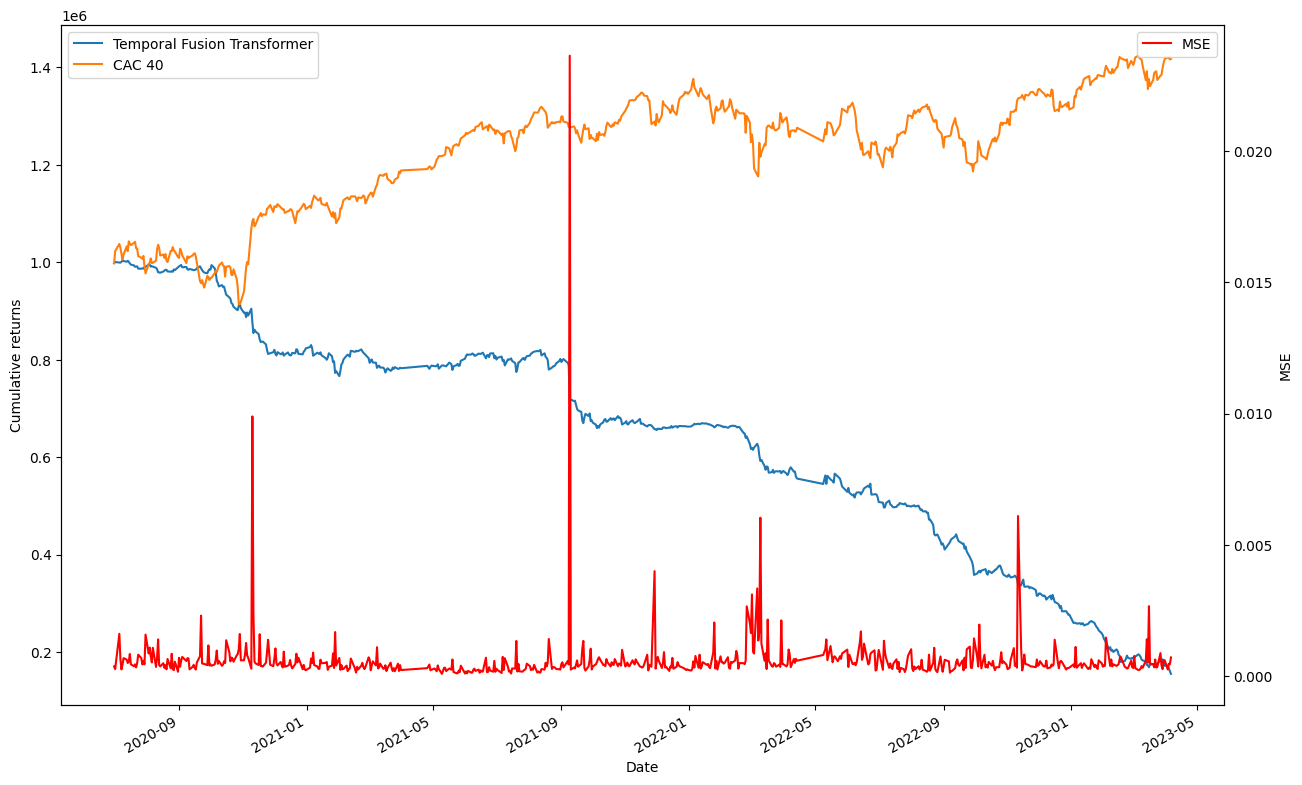

In [258]:
backtest = BackTester(weights_test[model.name] , returns, capital, risk_free, benchmark=benchmark_returns, name = "Temporal Fusion Transformer")
rets, cum_rets = backtest.run_backtest()
backtest_statistics = backtest.get_backtest_statistics()
cum_returns = backtest.get_strategy_cumulative_returns()
# forecasts_test_sign = 2*forecasts_test-1 # classification in 0/1
# cum_returns["Missclassification rate"] = (forecasts_test_sign != np.sign(returns.loc[test_index_full, :])).abs().mean(axis = 1).cumsum()
cum_returns["MSE"] = (forecasts_test - returns.loc[test_index_full, :]).apply(lambda x: x**2).mean(axis = 1)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
cum_returns.plot(y = ["Temporal Fusion Transformer", "CAC 40"], ax = ax1, figsize = (15, 10))
cum_returns.plot(y = "MSE", ax = ax2, color = "red")
ax1.set_ylabel("Cumulative returns")
ax2.set_ylabel("MSE")

In [260]:
backtest_statistics

Yearly excess returns         -0.323120
Yearly standard deviation      0.100796
Max DD                       242.410744
Yearly Sharpe                 -3.205673
Yearly Calmar                 -0.001333
Yearly Sortino                -3.559391
Daily Turnover                 0.076217
dtype: float64

In [262]:
backtest_statistics.to_csv(f"Statistics/backtestbacktest_statistics_tft_{model.type}.csv")

In [228]:
(forecasts_test_sign != np.sign(returns.loc[test_index_full, :])).abs().mean(axis = 1).mean()

0.49062998405103714

In [261]:
cum_returns["MSE"].sum()

0.39181215728967095